In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os
# import eofs.standard as Eof_st
# from eofs.multivariate.standard import MultivariateEof

from scipy.signal import butter, lfilter
from scipy.signal import convolve

# import utilities

# import importlib
# def reimport_module(module_name):
#     """
#     Reimports the specified Python module.
    
#     Args:
#     module_name (module): The module to be reimported, typically passed as a variable.
    
#     Returns:
#     module: The reloaded module.
#     """
#     try:
#         # Reload the already imported module
#         reloaded_module = importlib.reload(module_name)
#         print(f"Module {module_name.__name__} reloaded successfully.")
#         return reloaded_module
#     except Exception as e:
#         print(f"Failed to reload module: {e}")

# reimport_module(utilities)

In [9]:
din = '/glade/campaign/cgd/tss/people/mdfowler/GustProject/GustFix/FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF_withFix_DerchoTest.006/atm/hist/'
fin = 'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF_withFix_DerchoTest.006.cam.h1a.0004-09-28-00000.nc' 
xr.open_dataset(din+fin)

<xarray.Dataset>
Dimensions:       (ilev: 59, lat: 192, lev: 58, lon: 288, nbnd: 2, time: 31, trop_cld_lev: 58)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.3 357.5 358.8
  * lev           (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev          (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * trop_cld_lev  (trop_cld_lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * time          (time) object 0004-09-27 12:00:00 ... 0004-10-27 12:00:00
Dimensions without coordinates: nbnd
Data variables: (12/35)
    w             (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    date          (time) int32 ...
    ...            ...
    U10           (time, lat, lon) float32 ...
    U200          (time, lat, lon) float32 ...
    U850          (time, lat, lon) float32 ...
    UGUST         (time, lat, lon) float32 ...
    V200          (time, lat, lon) float32 ...
    V850          (time, lat, lon) float32 ...
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam...
    logname:           mdfowler
    host:              derecho1
    initial_file:      f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001.cam.i.1994-01...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  day_1

In [1]:
from windspharm.xarray import VectorWind


In [7]:
def bandpass_filter_via_fft_3d_OG(data, low_period, high_period, sampling_interval=1):
    """
    Apply a bandpass filter to a 3D time series (time, lat, lon) using FFT and inverse FFT.
    
    Parameters:
    - data: numpy array, the input time series data of shape (time, lat, lon).
    - low_period: float, the lower bound of the period (in days) to allow through the filter.
    - high_period: float, the upper bound of the period (in days) to allow through the filter.
    - sampling_interval: float, the sampling interval of the time series (default is 1 day).
    
    Returns:
    - filtered_data: numpy array, the bandpass-filtered time series.
    """
    # Initialize the output array with the same shape as input data
    filtered_data = np.empty_like(data)

    # Loop over each spatial point
    for i in range(data.shape[1]):  # latitude
        for j in range(data.shape[2]):  # longitude
            # Extract the time series at each point
            time_series = data[:, i, j]
            
            # Perform FFT on the original data
            fft_data = np.fft.fft(time_series)
            n = len(fft_data)
            
            # Generate frequency axis and define bandpass frequency limits
            frequencies = np.fft.fftfreq(n, d=sampling_interval)
            f_low = 1 / high_period  # Convert period to frequency
            f_high = 1 / low_period  # Convert period to frequency

            # Create a bandpass filter mask
            bandpass_mask = (np.abs(frequencies) >= f_low) & (np.abs(frequencies) <= f_high)

            # Apply the mask to the FFT data
            filtered_fft_data = fft_data * bandpass_mask

            # Apply inverse FFT to get the filtered time series back in the time domain
            filtered_time_series = np.fft.ifft(filtered_fft_data).real

            # Store the filtered time series back in the corresponding array slice
            filtered_data[:, i, j] = filtered_time_series

    return filtered_data

In [8]:
# precip: 
dir_in = '/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts'
filolr =  'ERA5.h1.FLUT.anomalies.1979010100000-2010123100000.nc'
var_name_olr = 'FLUT'
file_path_olr = os.path.join(dir_in, filolr)  # Join the directory and file name
DS_olr = xr.open_dataset(file_path_olr)


In [22]:
%%time
# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period

olr_f_1 = bandpass_filter_via_fft_3d(np.array(DS_olr.isel(time=slice(1,10000))[var_name_olr]), f_high, f_low, sampling_interval = 1)
# DS_olr['OLR_f'] = (('time', 'lat', 'lon'), olr_f)
# print('filt OLR')

CPU times: user 43 s, sys: 6.4 s, total: 49.4 s
Wall time: 1min 43s


In [23]:
%%time
# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period

olr_f_2 = bandpass_filter_via_fft_3d_OG(np.array(DS_olr.isel(time=slice(1,10000))[var_name_olr]), f_high, f_low, sampling_interval = 1)
# DS_olr['OLR_f'] = (('time', 'lat', 'lon'), olr_f)
# print('filt OLR')

CPU times: user 59.3 s, sys: 1.58 s, total: 1min
Wall time: 2min 7s


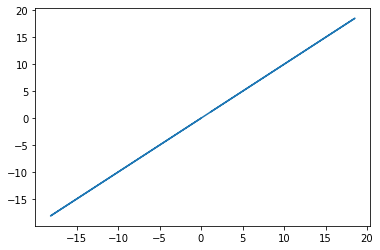

In [24]:
plt.plot(olr_f_1[:,20,20],olr_f_2[:,20,20])

In [4]:
dir_in = '/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts'
filu200 = 'ERA5.h1.U200.anomalies.1979010100000-1993123100000.nc' 
var_name_u200 = 'U200'
filv200 = 'ERA5.h1.V200.anomalies.1979010100000-1993123100000.nc' 
var_name_v200 = 'V200'

# u200: 
file_path_u200 = os.path.join(dir_in, filu200)  # Join the directory and file name
DS_u200 = xr.open_dataset(file_path_u200)
file_path_v200 = os.path.join(dir_in, filv200)  # Join the directory and file name
DS_v200 = xr.open_dataset(file_path_v200)

In [5]:
uwnd = DS_u200['U200']
vwnd = DS_v200['V200']

# Create a VectorWind instance to handle the computation of streamfunction and
# velocity potential.
w = VectorWind(uwnd, vwnd)


ValueError: equally-spaced latitudes are invalid (they may be non-global)

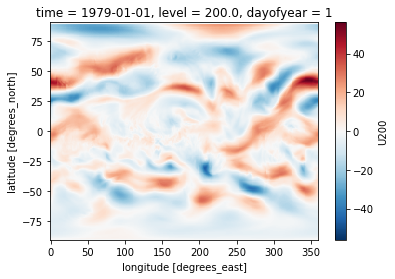

In [12]:
uwnd.isel(time=0).plot()

In [14]:
ls /glade/derecho/scratch/wchapman/ADF/ERA5_data/ts

ERA5.h1.FLUT.1979010100000-1993123100000.nc
ERA5.h1.FLUT.anomalies.1979010100000-1993123100000.nc
ERA5.h1.Lagged_MJO_TS_FLUT_U850.png
ERA5.h1.MJO_BIAS_COMPOSITE_EOFS_FLUT_U200_U850.png
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase001.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase002.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase003.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase004.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase005.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase006.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase007.nc
ERA5.h1.MJO_Bootstrapped_COMPOSITE_EOFS_FLUT_U200_U850_phase008.nc
ERA5.h1.MJO_COMPOSITE_EOFS_FLUT_U200_U850.png
ERA5.h1.MJO_COMPOSITE_Telconnections_FLUT_U200_U850_MJO_Bootstrap_phase_02_03_JFM.nc
ERA5.h1.MJO_COMPOSITE_Telconnections_FLUT_U200_U850_MJO_Bootstrap_phase_02_03_OND.nc
ERA5.h1.MJO_COMPOSITE_Telconnections_FLUT_U200_U850_MJO_Bootstr

In [3]:
! pip install xbootstrap

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2020/gpcp_v01r03_daily_d20200225_c20200509.nc

In [13]:
DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo/ts/climo/PRECT_1979-01-15_climo.nc')
DS2 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo/ts/climo/PRECT_1979-04-15_climo.nc')

In [25]:
DS1 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts/climo/precip_1979-01-15_climo.nc')
DS2 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/ERA5_data/ts/climo/precip_1979-04-15_climo.nc')